In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Required Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
from copy import copy, deepcopy
import pytz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from pickle import dump, load

For Formatting Console Print Commands - ANSI Escape Code

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# **Import Data**

In [4]:
file_path = '/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/SCiBER.csv'
df = pd.read_csv(file_path)
print(df)

                    Date  Garden  School  Tunnel  Other  Other.1   Zoo  \
0       01.01.2013 00:15     9.5    10.4    24.0   48.0      5.0  64.0   
1       01.01.2013 00:30     8.6    10.6    24.0   46.0      4.8  66.0   
2       01.01.2013 00:45     5.5    10.5    26.0   48.0      4.4  66.0   
3       01.01.2013 01:00     5.5    10.5    24.0   48.0      5.4  64.0   
4       01.01.2013 01:15     5.4    10.6    22.0   48.0      3.6  62.0   
...                  ...     ...     ...     ...    ...      ...   ...   
140155  31.12.2016 23:00     9.3    10.2     NaN   28.0      NaN  76.0   
140156  31.12.2016 23:15     9.4     8.8     NaN   28.0      NaN  76.0   
140157  31.12.2016 23:30     5.8     6.4     NaN   26.0      NaN  80.0   
140158  31.12.2016 23:45     4.9     6.6     NaN   28.0      NaN  78.0   
140159  01.01.2017 00:00     7.2     6.2     NaN   28.0      NaN  80.0   

        Event hall  School.1  School.2  ...  School.36  (Pre-)School.2  \
0             29.4       4.2      20.

# **Pre-process Dataset**
**Convert first coumn to Pandas DateTime Object**

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M')

**Extract names of columns which are complete**

In [6]:
df_list = list(df.head(0))
complete_columns = [] # Variable to store names of extracted columns
for column in df_list:
    bool_series = pd.isnull(df[column])
    num_null = bool_series[bool_series].index.size # Calculate the number of null encounters
    if num_null == 5:
        complete_columns.append(column)
print(complete_columns)
office_idx_in_cc = []
for idx, column in enumerate(complete_columns):
    if 'Office' in column:
        print(idx, column)
        office_idx_in_cc.append(idx)
print(office_idx_in_cc, len(office_idx_in_cc))

['Garden', 'School', 'Other', 'Zoo', 'Event hall', 'School.1', 'School.2', 'School.3', 'Graveyard', 'Office building', 'Other.2', 'Office building.1', 'School.4', 'Office building.4', 'Office building.5', 'School.5', 'Other.3', 'Swimming Pool', 'Swimming Pool.1', 'Swimming Pool.2', 'Office building.8', 'Gym.1', 'Office building.9', 'Office building.10', 'Office building.11', 'Graveyard.1', 'Firefighters', 'School.10', '(Pre-)School', 'Office building.13', 'Event hall.2', 'Office building.14', 'Office building.15', 'School.20', 'Swimming Pool.3', 'Swimming Pool.4', 'Swimming Pool.5', 'School.25', 'Garage.1']
9 Office building
11 Office building.1
13 Office building.4
14 Office building.5
20 Office building.8
22 Office building.9
23 Office building.10
24 Office building.11
29 Office building.13
31 Office building.14
32 Office building.15
[9, 11, 13, 14, 20, 22, 23, 24, 29, 31, 32] 11


**Make Date column continuous by appending NANs if required**

In [7]:
print(len(df.index))
flag = 0
while flag == 0:
    print('Inside While LOOP...')
    prev_value = 0
    for key, value in df['Date'].iteritems():
        flag = 1
        if not prev_value == 0:
            time_diff = (value - prev_value).total_seconds() / 60.0
            if not (time_diff == 15 or time_diff == 75 or time_diff == -45):
                err_key = key
                print('Found error at key =', err_key, 'and time_diff =', time_diff)
                print('Proof of error:', err_key, value, prev_value, time_diff)
                df = pd.concat([df.iloc[:err_key], pd.DataFrame({'Date': prev_value + pd.Timedelta(pd.offsets.Minute(15))}, index=[err_key]), df.iloc[err_key:]]).reset_index(drop=True)
                prev_value = prev_value + pd.Timedelta(pd.offsets.Minute(15))
                err_key += 1
                time_diff -= 15
                while not time_diff == 15:
                    df = pd.concat([df.iloc[:err_key], pd.DataFrame({'Date': prev_value + pd.Timedelta(pd.offsets.Minute(15))}, index=[err_key]), df.iloc[err_key:]]).reset_index(drop=True)
                    prev_value = prev_value + pd.Timedelta(pd.offsets.Minute(15))
                    err_key += 1
                    time_diff -= 15
                flag = 0
                break
        prev_value = value
print(len(df.index))

140160
Inside While LOOP...
Found error at key = 119612 and time_diff = 1455.0
Proof of error: 119612 2016-06-01 00:15:00 2016-05-31 00:00:00 1455.0
Inside While LOOP...
140256


**Add a column of Dates without DST adjustment**

In [8]:
dateSeries = deepcopy(df['Date'])
dateSeries.dt.tz_localize(tz='Europe/Berlin', ambiguous='infer')
# Create a list of start and end dates for DST in each year, in UTC time
dst_changes_utc = pytz.timezone('Europe/Berlin')._utc_transition_times[1:]
# Convert to local times from UTC times and then remove timezone information
dst_changes = [pd.Timestamp(i).tz_localize('UTC').tz_convert('Europe/Berlin').tz_localize(None) for i in dst_changes_utc]
dst_flags = []
flag = 0
counter = 0
for index, row in dateSeries.iteritems():
    # Isolate the start and end dates for DST in each year
    dst_dates_in_year = [date for date in dst_changes if date.year == row.year]
    spring = dst_dates_in_year[0]
    fall = dst_dates_in_year[1]
    # If DateTime falls in between DST Hours
    if (row >= spring) & (row < fall):
        dateSeries[index] -= pd.Timedelta(pd.offsets.Minute(60))
        dst_flags.append(1)
        flag = 1
    # Adjust 4 more readings which duplicate in Fall
    elif flag==1:
        dateSeries[index] -= pd.Timedelta(pd.offsets.Minute(60))
        counter+=1
        dst_flags.append(1)
        if counter==4:
            flag = 0
            counter = 0
    else:
        dst_flags.append(0)
df['DateNoDST'] = dateSeries
df['DSTflags'] = dst_flags

**Add Weekday Name Column to the DataFrame**

In [9]:
df['Day'] = df['Date'].dt.day_name()
print(df.head())

                 Date  Garden  School  Tunnel  Other  Other.1   Zoo  \
0 2013-01-01 00:15:00     9.5    10.4    24.0   48.0      5.0  64.0   
1 2013-01-01 00:30:00     8.6    10.6    24.0   46.0      4.8  66.0   
2 2013-01-01 00:45:00     5.5    10.5    26.0   48.0      4.4  66.0   
3 2013-01-01 01:00:00     5.5    10.5    24.0   48.0      5.4  64.0   
4 2013-01-01 01:15:00     5.4    10.6    22.0   48.0      3.6  62.0   

   Event hall  School.1  School.2  ...  School.37  Office building.18  Gym.2  \
0        29.4       4.2      20.2  ...        NaN                 NaN    NaN   
1        27.2       5.3      20.6  ...        NaN                 NaN    NaN   
2        27.6       4.9      23.0  ...        NaN                 NaN    NaN   
3        27.0       3.9      19.2  ...        NaN                 NaN    NaN   
4        27.0       3.9      19.4  ...        NaN                 NaN    NaN   

   Gym.3  School.38  School.39  School.40           DateNoDST  DSTflags  \
0    NaN        N

**Visualizations**

Plot data year-wise

In [10]:
new_df = deepcopy(df)
new_df['Year'] = new_df.DateNoDST.dt.year
new_df['DateNoDST'] = new_df.DateNoDST.dt.strftime('%m-%d %H:%M')
new_df[complete_columns[office_idx_in_cc[0]]] = new_df[complete_columns[office_idx_in_cc[0]]].mask(new_df[complete_columns[office_idx_in_cc[0]]] < 4, np.nan)
print(new_df.head())
unstacked_1 = new_df.set_index(['Year', 'DateNoDST'])[complete_columns[office_idx_in_cc[0]]][:-1].unstack(0)
#unstacked_1 = new_df.pivot('DateNoDST', 'Year', complete_columns[1])
#print(unstacked_1)
plt.rc('font', size=22)         # controls default text sizes
plt.rc('axes', titlesize=22)    # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)   # fontsize of the tick labels
plt.rc('ytick', labelsize=24)   # fontsize of the tick labels
plt.rc('legend', fontsize=26)   # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title
unstacked_1.plot(figsize=(20, 12), xlabel='Timestamp', ylabel='Electricity Consumption (in kW)')
plt.xticks(rotation=20)
plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/year-wise-data.pdf", bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

                 Date  Garden  School  Tunnel  Other  Other.1   Zoo  \
0 2013-01-01 00:15:00     9.5    10.4    24.0   48.0      5.0  64.0   
1 2013-01-01 00:30:00     8.6    10.6    24.0   46.0      4.8  66.0   
2 2013-01-01 00:45:00     5.5    10.5    26.0   48.0      4.4  66.0   
3 2013-01-01 01:00:00     5.5    10.5    24.0   48.0      5.4  64.0   
4 2013-01-01 01:15:00     5.4    10.6    22.0   48.0      3.6  62.0   

   Event hall  School.1  School.2  ...  Office building.18  Gym.2  Gym.3  \
0        29.4       4.2      20.2  ...                 NaN    NaN    NaN   
1        27.2       5.3      20.6  ...                 NaN    NaN    NaN   
2        27.6       4.9      23.0  ...                 NaN    NaN    NaN   
3        27.0       3.9      19.2  ...                 NaN    NaN    NaN   
4        27.0       3.9      19.4  ...                 NaN    NaN    NaN   

   School.38  School.39  School.40    DateNoDST  DSTflags      Day  Year  
0        NaN        NaN        NaN  01-01

Plot Data Complete on Top of Each Other

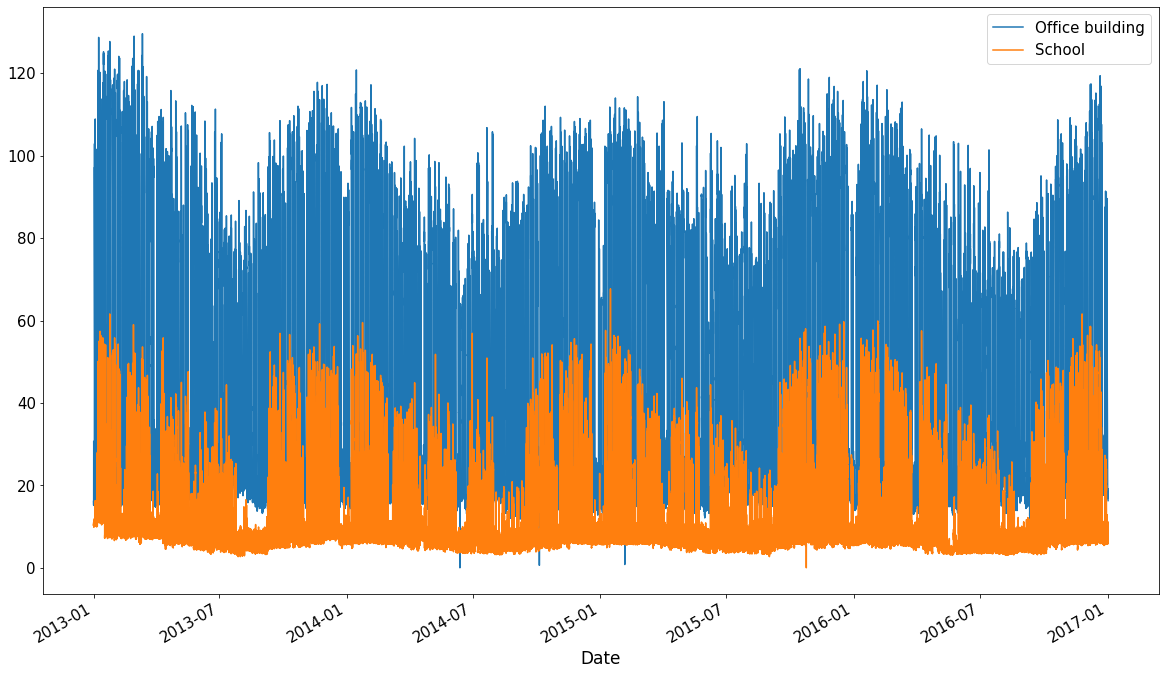

In [11]:
plt.rc('font', size=15)         # controls default text sizes
plt.rc('axes', titlesize=17)    # fontsize of the axes title
plt.rc('axes', labelsize=17)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)   # fontsize of the tick labels
plt.rc('ytick', labelsize=15)   # fontsize of the tick labels
plt.rc('legend', fontsize=15)   # legend fontsize
plt.rc('figure', titlesize=17)  # fontsize of the figure title
ax = df.plot(x="Date", y=[complete_columns[office_idx_in_cc[0]], complete_columns[1]], figsize=(20, 12))

Plots to Estimate Periodicity

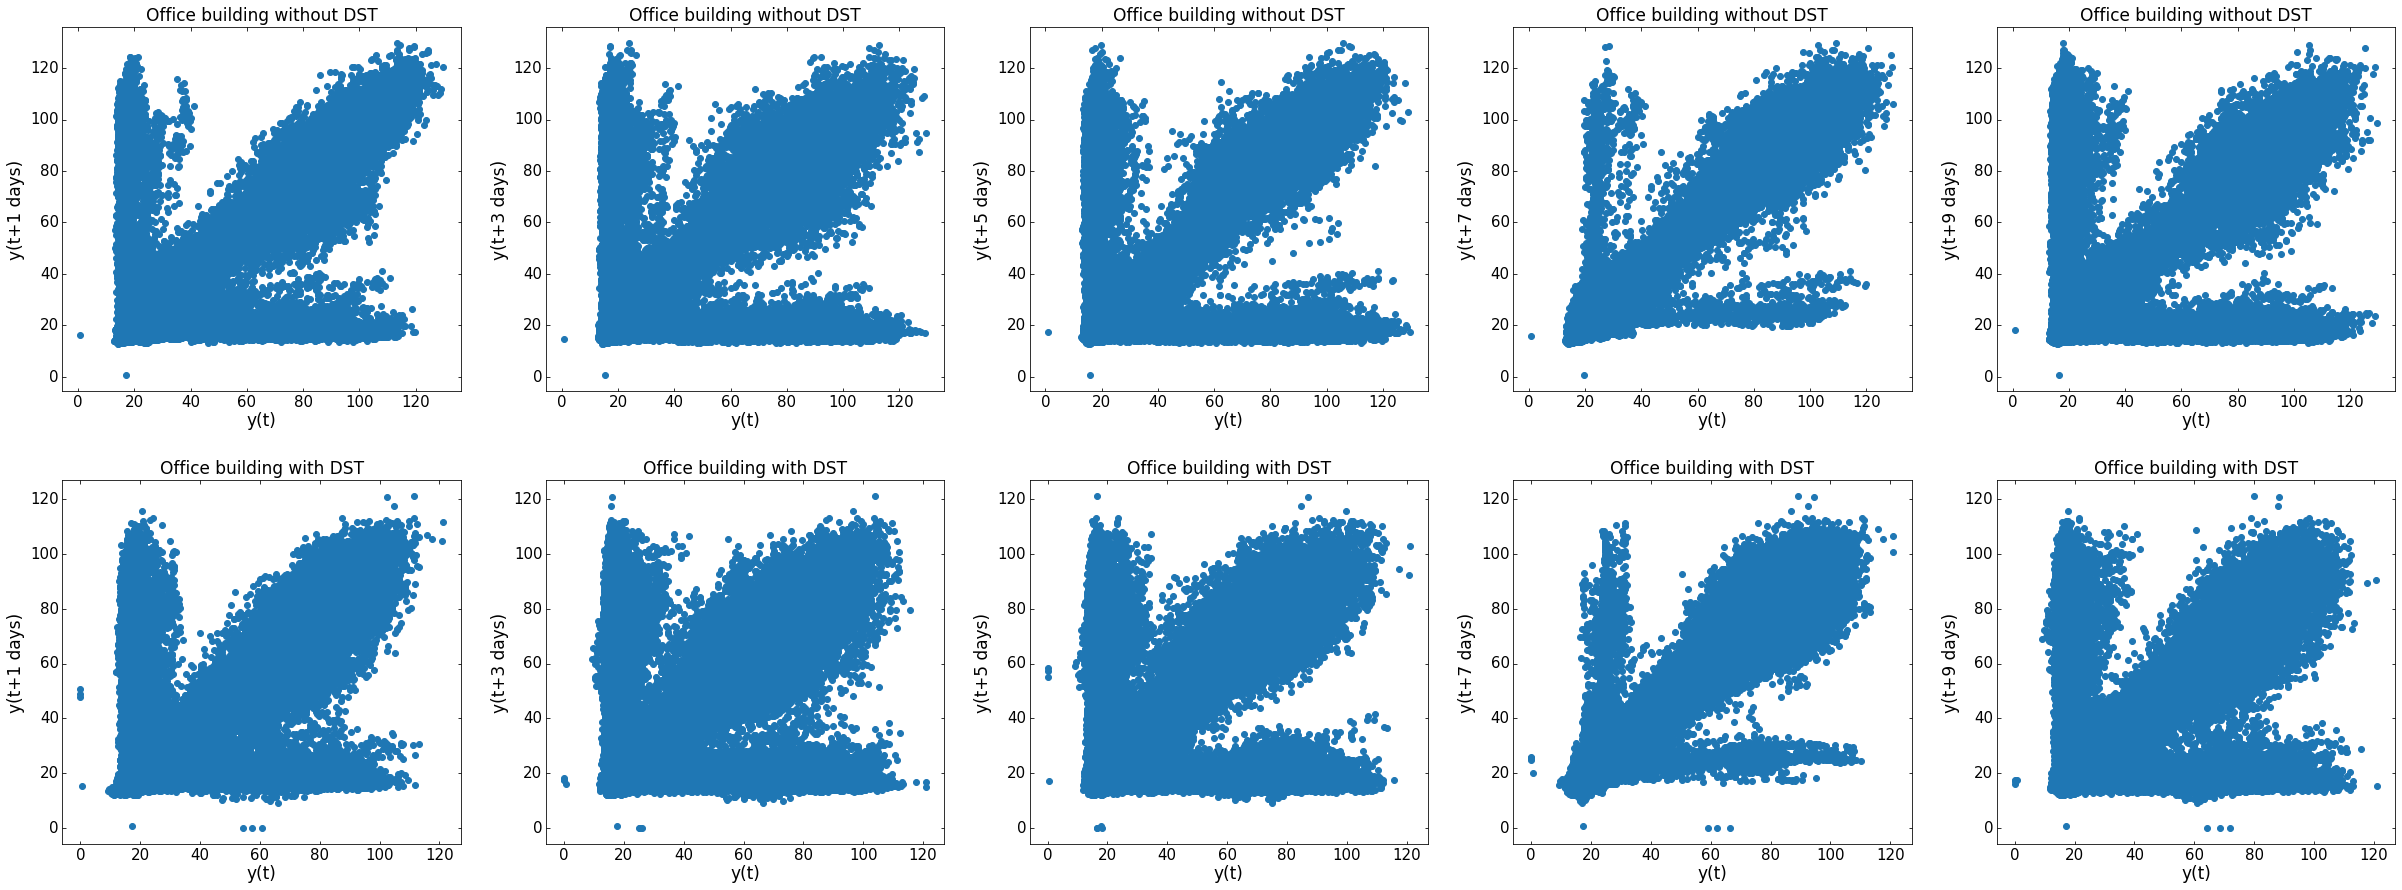

In [12]:
fig = plt.figure(figsize=(34,13))
for i in range(1,10,2):
    for dstFlag, gp in df.groupby('DSTflags'):
        ax = Subplot(fig, 2,5,(dstFlag*5)+int(((i-1)/2)+1))
        fig.add_subplot(ax)
        pd.plotting.lag_plot(gp[complete_columns[office_idx_in_cc[0]]], lag=i*96)
        ax.set_ylabel('y(t+'+str(i)+' days)')
        if dstFlag==0:
            ax.set_title(complete_columns[office_idx_in_cc[0]] + ' without DST')
        else:
            ax.set_title(complete_columns[office_idx_in_cc[0]] + ' with DST')
fig.tight_layout(pad=2.0)

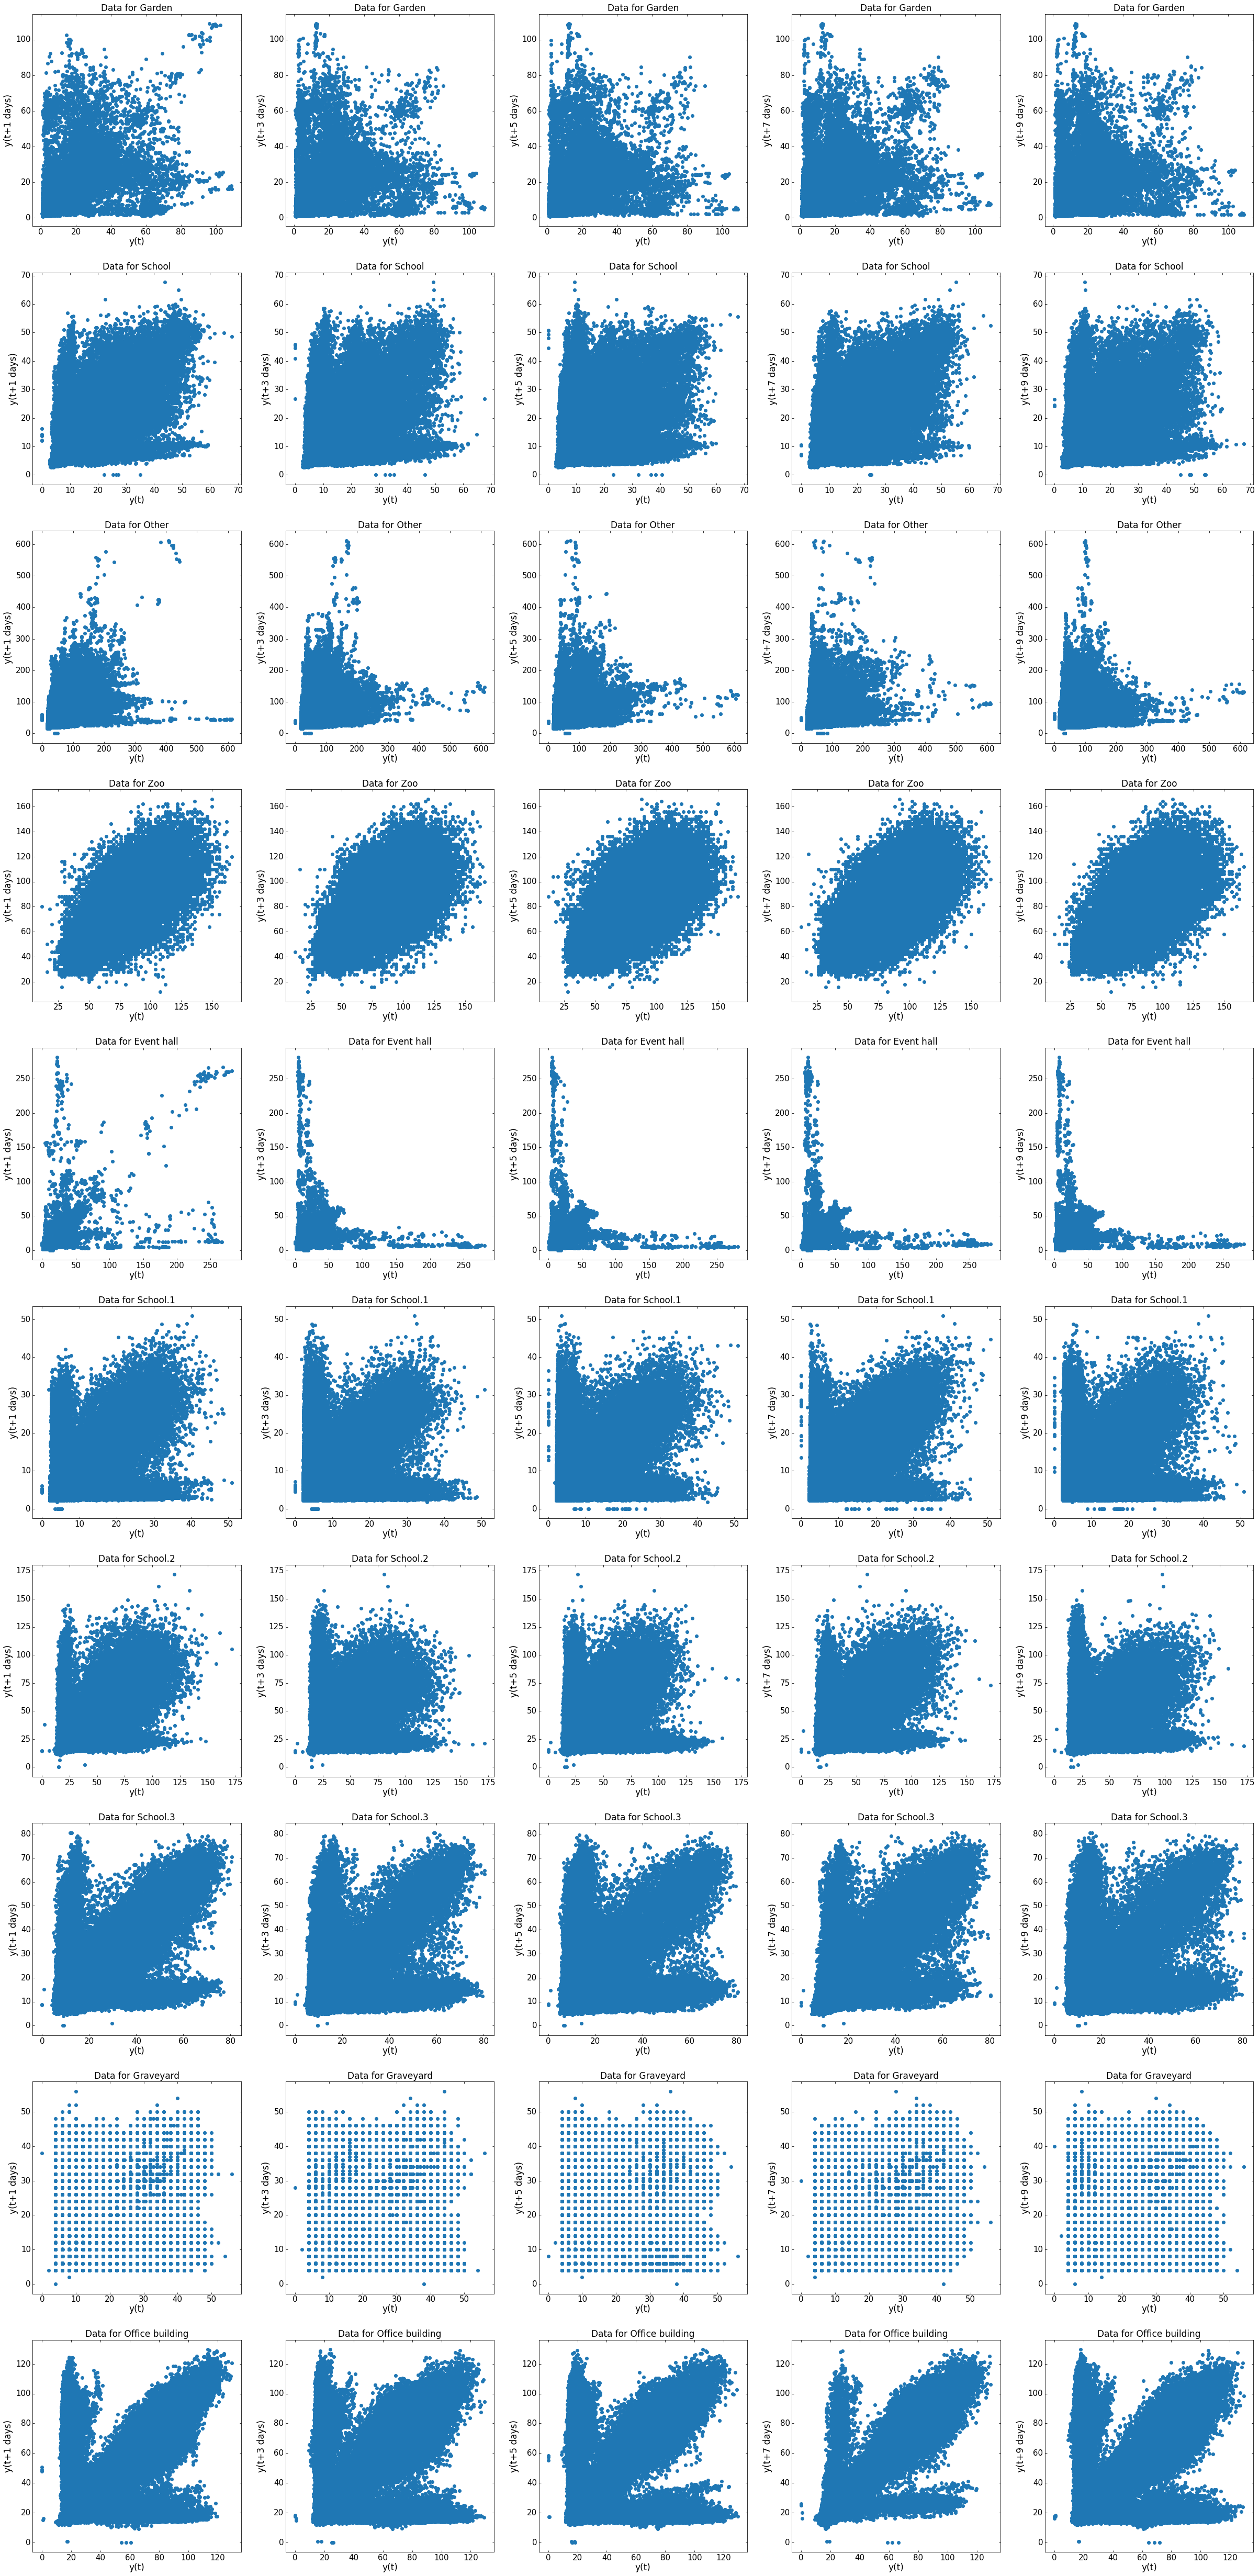

In [13]:
fig = plt.figure(figsize=(34,69))
for j in range(10):
    for i in range(1,10,2):
        ax = Subplot(fig, 10,5,j*5+int(((i-1)/2)+1))
        fig.add_subplot(ax)
        #ax = fig.add_subplot(1,5,int(((i-1)/2)+1))
        pd.plotting.lag_plot(df[complete_columns[j]], lag=i*96)
        ax.set_ylabel('y(t+'+str(i)+' days)')
        ax.set_title('Data for ' + complete_columns[j])
fig.tight_layout(pad=2.0)
#plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/LagPlotsSCiBER.pdf", bbox_inches = 'tight', pad_inches = 0.05)
#plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/LagPlotsSCiBER.png", bbox_inches = 'tight', pad_inches = 0.05)
#plt.close()

**More about a single Building**

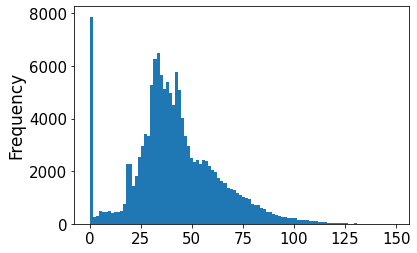

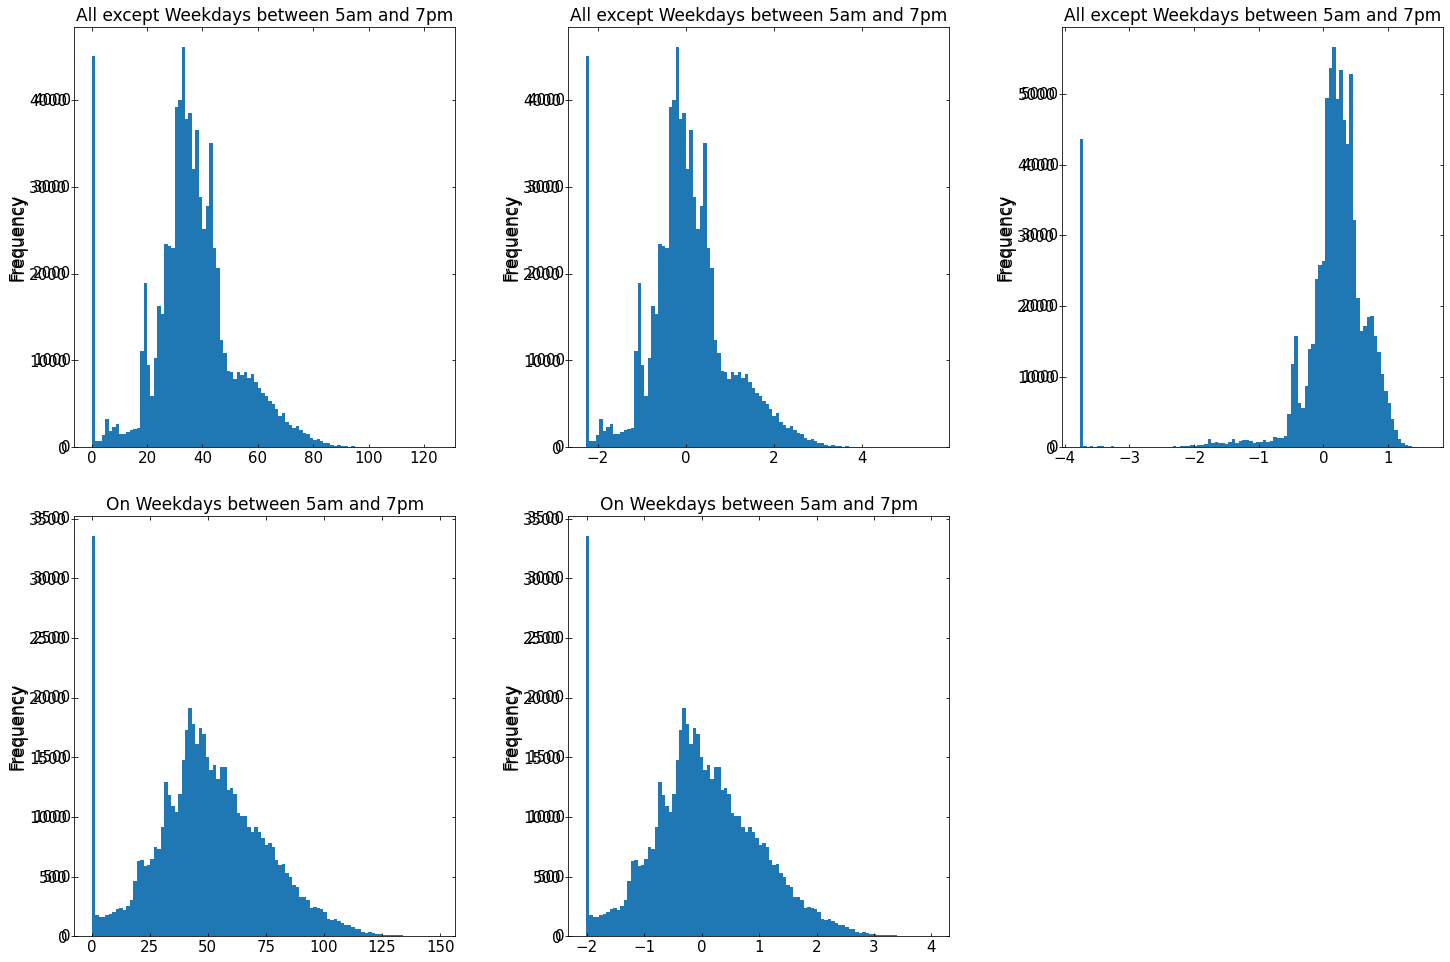

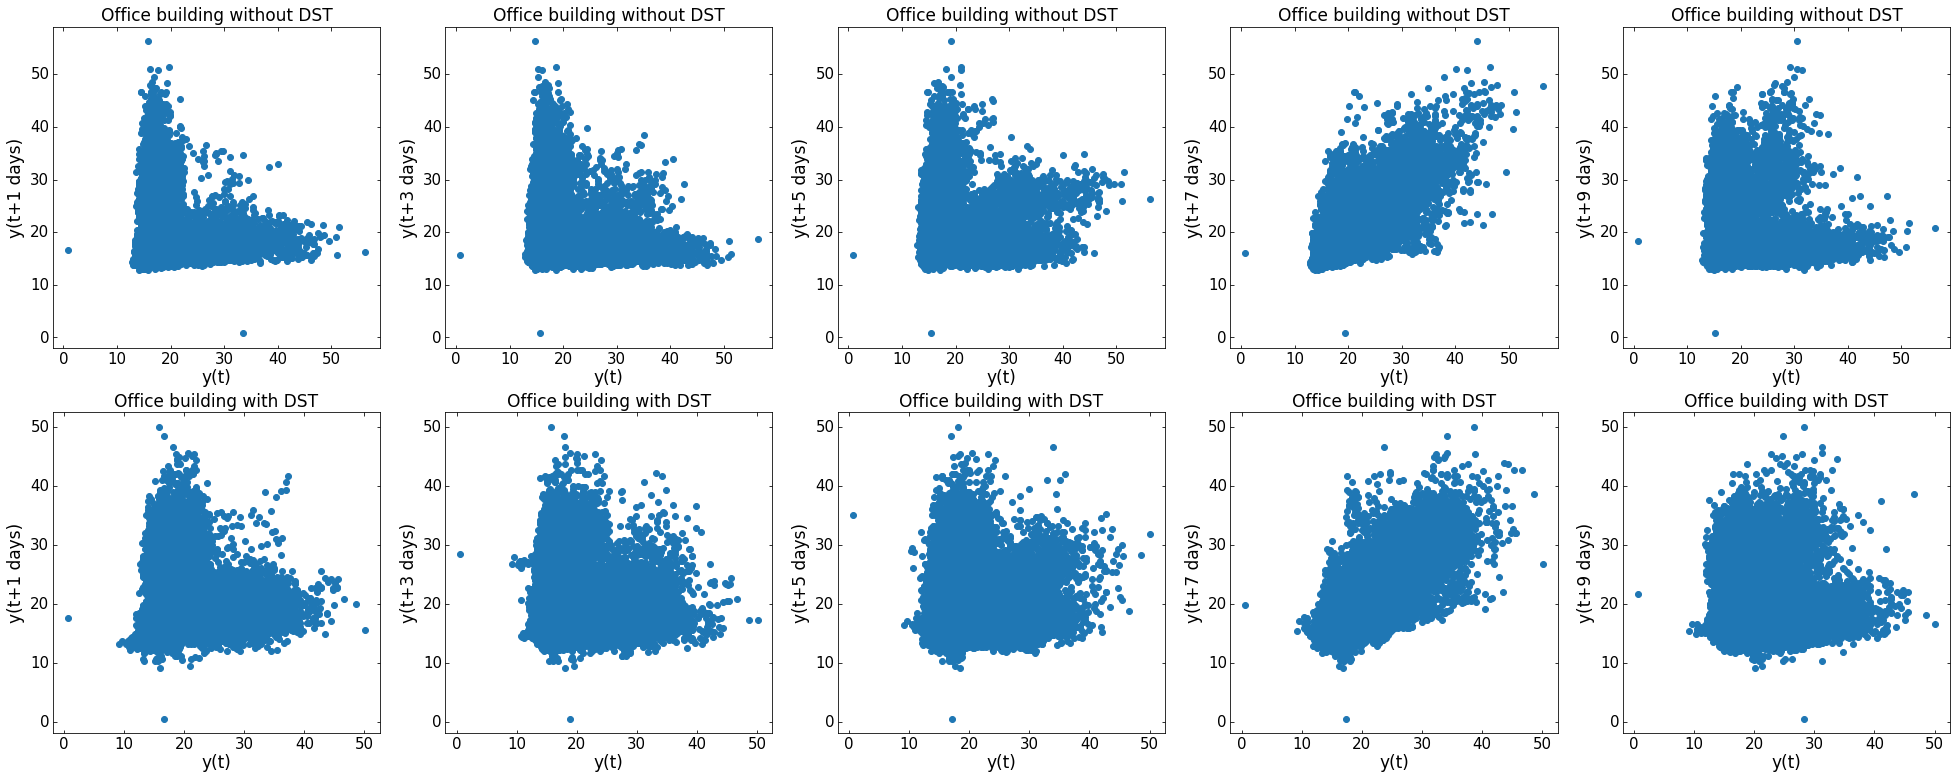

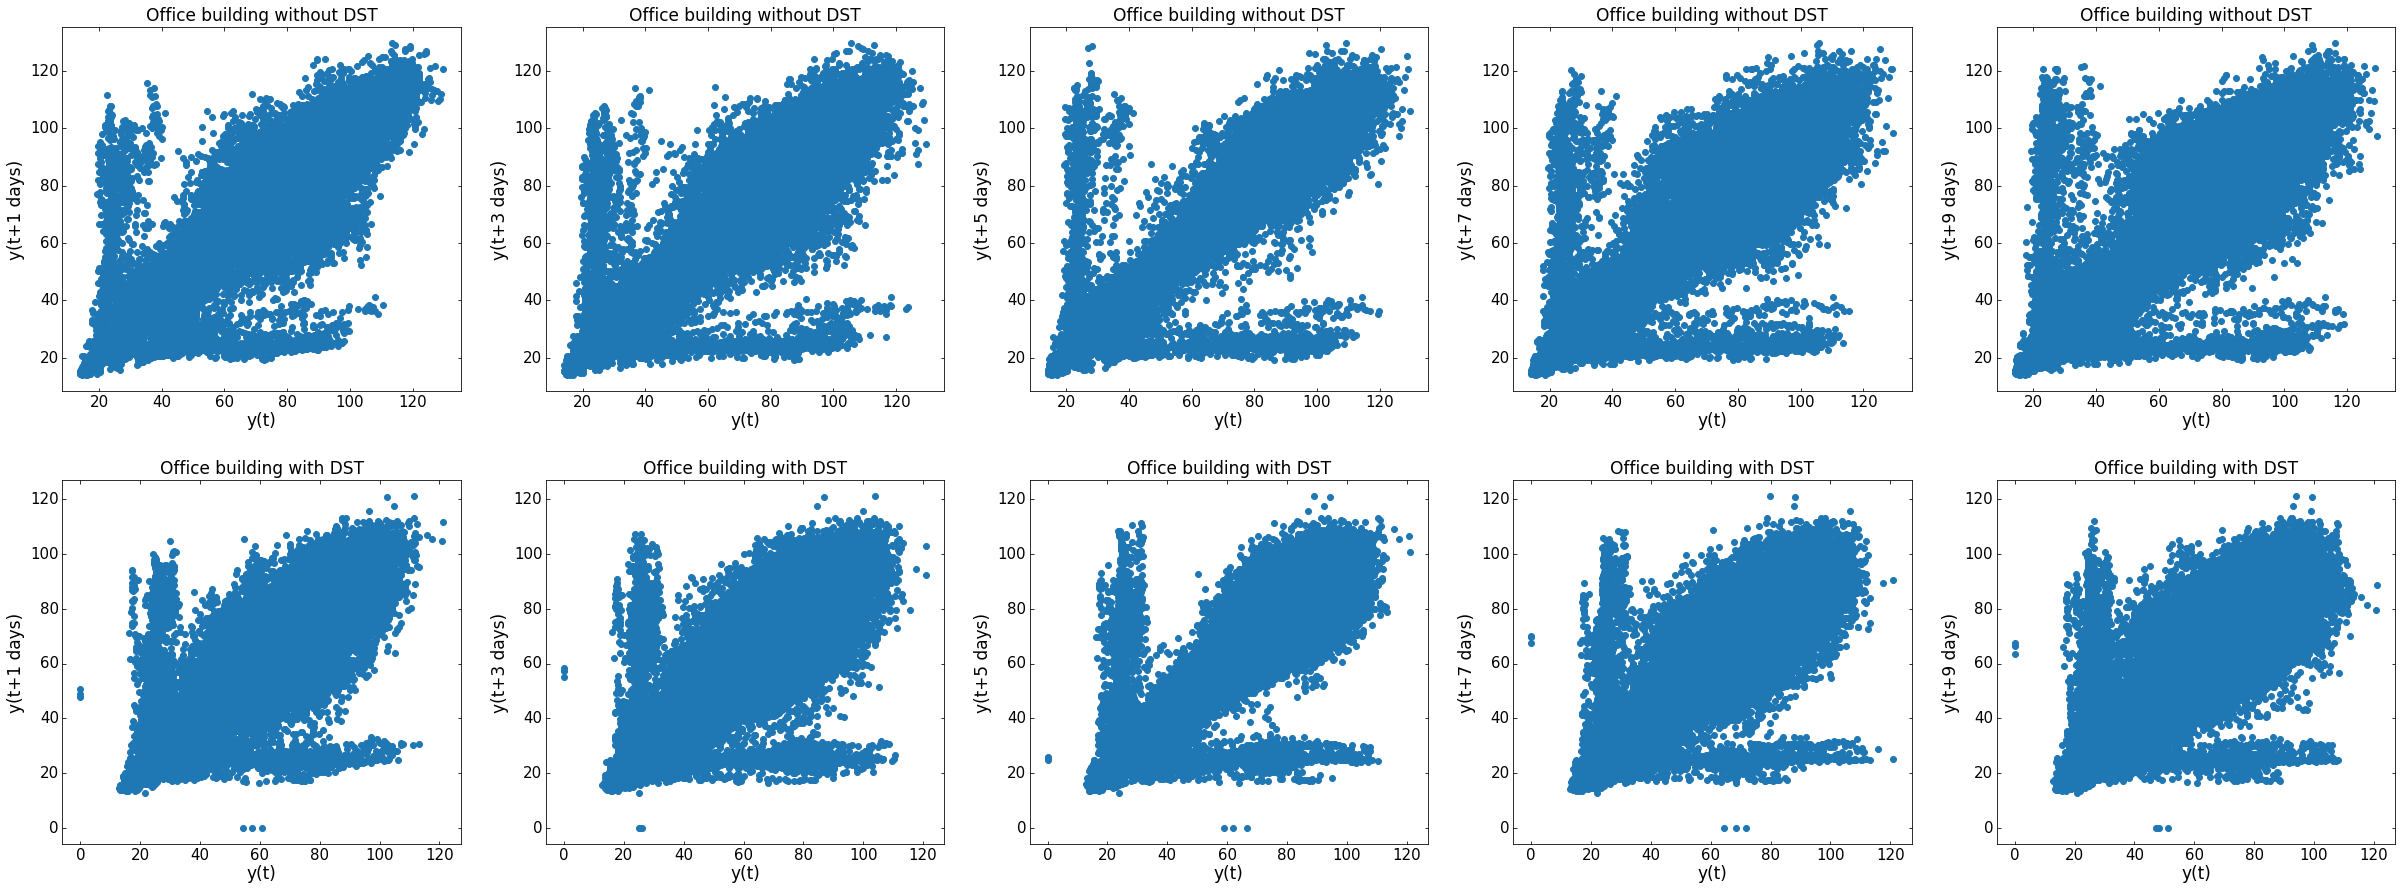

In [14]:
# Function to check if the given datetime object is from a weekday or not
def check_weekday(datetime):
    # computing the parameter date
    # with len function
    res=len(pd.bdate_range(datetime,datetime))
    if res == 0 :
        return False
    else:
        return True

buildingName = complete_columns[office_idx_in_cc[2]] # Tentative Working Hours: start_time - end_time (MON-FRI)
df[buildingName].plot.hist(bins=100)
start_time = 5
end_time = 19
'''
thresholdValue = 40
start = 21
end = 23
buildingData = deepcopy(df[buildingName])
binaryFlags = []
for index, row in buildingData.iteritems():
    if row<=thresholdValue:
        binaryFlags.append(0)
    else:
        binaryFlags.append(1)
plt.figure(figsize=(30,6))
plt.plot(df['Date'][96*start:96*end], binaryFlags[96*start:96*end])
'''
## CREATE A FLAG FOR start_time - end_time FROM MONDAY TO FRIDAY
dateSeries = deepcopy(df['Date'])
dateSeries.dt.tz_localize(tz='Europe/Berlin', ambiguous='infer')
work_hour_flags = []
flag = 0
counter = 0
for index, row in dateSeries.iteritems():
    if (dateSeries[index].hour >= start_time) and (dateSeries[index].hour < end_time) and check_weekday(dateSeries[index]):
        work_hour_flags.append(1)
    else:
        work_hour_flags.append(0)
df['work_hour_series'] = work_hour_flags
fig = plt.figure(figsize=(21,14))
for workHour, gp in df.groupby('work_hour_series'):
    if workHour==1:
        # Plot Original
        ax = Subplot(fig, 2,3,4)
        fig.add_subplot(ax)
        gp[buildingName].plot.hist(bins=100)
        ax.set_title('On Weekdays between ' + str(start_time) + 'am and ' + str(end_time-12) + 'pm')
        ax.set_ylabel('Frequency')
        # Plot Standard Scaled
        ax = Subplot(fig, 2,3,5)
        fig.add_subplot(ax)
        values = gp[buildingName].to_numpy(copy=True).reshape(-1,1)
        scaler = StandardScaler()
        scaler = scaler.fit(values)
        gp[buildingName] = scaler.transform(values)
        gp[buildingName].plot.hist(bins=100)
        ax.set_title('On Weekdays between ' + str(start_time) + 'am and ' + str(end_time-12) + 'pm')
        ax.set_ylabel('Frequency')
    else:
        # Plot Original
        ax = Subplot(fig, 2,3,1)
        fig.add_subplot(ax)
        gp[buildingName].plot.hist(bins=100)
        ax.set_title('All except Weekdays between ' + str(start_time) + 'am and ' + str(end_time-12) + 'pm')
        ax.set_ylabel('Frequency')
        # Plot Standard Scaled
        ax = Subplot(fig, 2,3,2)
        fig.add_subplot(ax)
        values = gp[buildingName].to_numpy(copy=True).reshape(-1,1)
        values1 = np.log(gp[buildingName]+1).to_numpy(copy=True).reshape(-1,1)
        scaler = StandardScaler()
        scaler = scaler.fit(values)
        gp[buildingName] = scaler.transform(values)
        gp[buildingName].plot.hist(bins=100)
        ax.set_title('All except Weekdays between ' + str(start_time) + 'am and ' + str(end_time-12) + 'pm')
        ax.set_ylabel('Frequency')
        # Plot Log-Transformed Standard Scaled
        ax = Subplot(fig, 2,3,3)
        fig.add_subplot(ax)
        scaler = StandardScaler()
        scaler = scaler.fit(values1)
        gp[buildingName] = scaler.transform(values1)
        gp[buildingName].plot.hist(bins=100)
        ax.set_title('All except Weekdays between ' + str(start_time) + 'am and ' + str(end_time-12) + 'pm')
        ax.set_ylabel('Frequency')
fig.tight_layout(pad=2.0)

for workHour, wgp in df.groupby('work_hour_series'):
    fig = plt.figure(figsize=(34,13))
    for i in range(1,10,2):
        for dstFlag, gp in wgp.groupby('DSTflags'):
            ax = Subplot(fig, 2,5,(dstFlag*5)+int(((i-1)/2)+1))
            fig.add_subplot(ax)
            pd.plotting.lag_plot(gp[complete_columns[9]], lag=i*56)
            ax.set_ylabel('y(t+'+str(i)+' days)')
            if dstFlag==0:
                ax.set_title(complete_columns[9] + ' without DST')
            else:
                ax.set_title(complete_columns[9] + ' with DST')
fig.tight_layout(pad=2.0)

**Identify Working Hours In The Time Series**

In [15]:
# Function to check if the given datetime object is from a weekday or not
def check_weekday(datetime):
    # computing the parameter date
    # with len function
    res=len(pd.bdate_range(datetime,datetime))
    if res == 0 :
        return False
    else:
        return True

# Tentative Working Hours: start_time - end_time (MON-FRI)
start_time = 5
end_time = 19
# Create a column for WORK_HOUR_FLAGS - 1 if Work Hour; 0 Otherwise
dateSeries = deepcopy(df['Date'])
dateSeries.dt.tz_localize(tz='Europe/Berlin', ambiguous='infer')
work_hour_flags = []
flag = 0
counter = 0
for index, row in dateSeries.iteritems():
    if (dateSeries[index].hour >= start_time) and (dateSeries[index].hour < end_time) and check_weekday(dateSeries[index]):
        work_hour_flags.append(1)
    else:
        work_hour_flags.append(0)
df['work_hour_series'] = work_hour_flags
# Create a Numpy Array for each office in complete_columns
# - overall it will be a 2D array with rows as offices and columns as time series

**Plot histograms and lag plots for Working and Non-Working Hours Separately**

In [16]:
buildingName = complete_columns[office_idx_in_cc[0]]

# Tentative Working Hours: start_time - end_time (MON-FRI)
start_time = 5
end_time = 19

plotsSave = True

for workHour, gp in df.groupby('work_hour_series'):
    gp[buildingName] = gp[buildingName].mask(gp[buildingName] <= 0, np.nan)
    if workHour==1: #i.e. its a working hour
        # Plot Density Histogram for Working Hours Partition
        fig, ax = plt.subplots(figsize=(12, 9))
        plt.rc('font', size=22)         # controls default text sizes
        plt.rc('axes', titlesize=22)    # fontsize of the axes title
        plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=24)   # fontsize of the tick labels
        plt.rc('ytick', labelsize=24)   # fontsize of the tick labels
        plt.rc('legend', fontsize=22)   # legend fontsize
        plt.rc('figure', titlesize=33)  # fontsize of the figure title
        #gp[buildingName].plot.hist(bins=50)
        gp[buildingName].plot(kind = "hist", density=True, bins=50, alpha = 0.65, label="Density Histogram")
        gp[buildingName].plot(kind = "kde", linewidth=3, label="Kernel Density Estimation")
        ax.set_xlim(0, gp[buildingName].max())
        ax.set_title('On weekdays during ' + str(start_time) + 'am - ' + str(end_time-12) + 'pm', size = 35, pad=15)
        ax.set_ylabel('Density', size=30)
        ax.set_xlabel('Electricity Consumption (in kW)', size=30)
        plt.legend()
        if plotsSave:
            plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/workingHoursHistogram.pdf", bbox_inches = 'tight', pad_inches = 0.05)
            plt.close()

        # Plot Lag-Plots for Working Hours Partition
        fig = plt.figure(figsize=(34,7))
        plt.rc('font', size=22)         # controls default text sizes
        plt.rc('axes', titlesize=22)    # fontsize of the axes title
        plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=24)   # fontsize of the tick labels
        plt.rc('ytick', labelsize=24)   # fontsize of the tick labels
        plt.rc('legend', fontsize=22)   # legend fontsize
        plt.rc('figure', titlesize=35)  # fontsize of the figure title
        for i in range(1,10,2):
            ax = Subplot(fig, 1,5,int((i+1)/2))
            fig.add_subplot(ax)
            pd.plotting.lag_plot(gp[buildingName], lag=i*56)
            ax.set_ylabel('Load Demand ($(t+'+str(i)+')^{th}$ day)')
            ax.set_xlabel('Load Demand ($t^{th}$ day)')
        fig.tight_layout(pad=2.0)
        if plotsSave:
            plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/lagPlotsWorkingHours.pdf", bbox_inches = 'tight', pad_inches = 0.05)
            plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/lagPlotsWorkingHours.png", bbox_inches = 'tight', pad_inches = 0.05)
            plt.close()
    else:
        # Plot Density Histogram for Non-Working Hours Partition
        fig, ax = plt.subplots(figsize=(12, 9))
        plt.rc('font', size=22)         # controls default text sizes
        plt.rc('axes', titlesize=22)    # fontsize of the axes title
        plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=24)   # fontsize of the tick labels
        plt.rc('ytick', labelsize=24)   # fontsize of the tick labels
        plt.rc('legend', fontsize=22)   # legend fontsize
        plt.rc('figure', titlesize=33)  # fontsize of the figure title
        #gp[buildingName].plot.hist(bins=50)
        gp[buildingName].plot(kind = "hist", density=True, bins=50, alpha = 0.65, label="Density Histogram")
        gp[buildingName].plot(kind = "kde", linewidth=3, label="Kernel Density Estimation")
        ax.set_xlim(0, gp[buildingName].max())
        ax.set_title('All except weekdays during ' + str(start_time) + 'am - ' + str(end_time-12) + 'pm', size = 35, pad=15)
        ax.set_ylabel('Density', size = 30)
        ax.set_xlabel('Electricity Consumption (in kW)', size=30)
        plt.legend()
        if plotsSave:
            plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/non-workingHoursHistogram.pdf", bbox_inches = 'tight', pad_inches = 0.05)
            plt.close()
        # Re-Plotting to confirm correct font-size settings
        fig, ax = plt.subplots(figsize=(12, 9))
        plt.rc('font', size=22)         # controls default text sizes
        plt.rc('axes', titlesize=22)    # fontsize of the axes title
        plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=24)   # fontsize of the tick labels
        plt.rc('ytick', labelsize=24)   # fontsize of the tick labels
        plt.rc('legend', fontsize=22)   # legend fontsize
        plt.rc('figure', titlesize=33)  # fontsize of the figure title
        #gp[buildingName].plot.hist(bins=50)
        gp[buildingName].plot(kind = "hist", density=True, bins=50, alpha = 0.65, label="Density Histogram")
        gp[buildingName].plot(kind = "kde", linewidth=3, label="Kernel Density Estimation")
        ax.set_xlim(0, gp[buildingName].max())
        ax.set_title('All except weekdays during ' + str(start_time) + 'am - ' + str(end_time-12) + 'pm', size = 35, pad=15)
        ax.set_ylabel('Density', size = 30)
        ax.set_xlabel('Electricity Consumption (in kW)', size=30)
        plt.legend()
        if plotsSave:
            plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/non-workingHoursHistogram.pdf", bbox_inches = 'tight', pad_inches = 0.05)
            plt.close()

# Plot Lag-Plots for Non-Working Hour Partition
temp_df = deepcopy(df)
temp_df[buildingName] = temp_df[buildingName].mask(temp_df['work_hour_series'] == 1, np.nan)
fig = plt.figure(figsize=(34,7))
plt.rc('font', size=22)         # controls default text sizes
plt.rc('axes', titlesize=22)    # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)   # fontsize of the tick labels
plt.rc('ytick', labelsize=24)   # fontsize of the tick labels
plt.rc('legend', fontsize=22)   # legend fontsize
plt.rc('figure', titlesize=35)  # fontsize of the figure title
for i in range(1,10,2):
    ax = Subplot(fig, 1,5,int((i+1)/2))
    fig.add_subplot(ax)
    pd.plotting.lag_plot(temp_df[buildingName], lag=i*96)
    ax.set_ylabel('Load Demand ($(t+'+str(i)+')^{th}$ day)')
    ax.set_xlabel('Load Demand ($t^{th}$ day)')
    #labels = ax.get_yticklabels()
    #labelsNew = [label.get_text() if (label.get_text().isspace() or len(label.get_text())==0) else format(int(label.get_text()), '03d') for label in labels]
    labelsNew = ['', '  0', ' 10', ' 20', ' 30', ' 40', ' 50', '']
    ax.set_yticklabels(labelsNew)
fig.tight_layout(pad=2.0)
if plotsSave:
    plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/lagPlotsNon-WorkingHours.pdf", bbox_inches = 'tight', pad_inches = 0.05)
    plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/lagPlotsNon-WorkingHours.png", bbox_inches = 'tight', pad_inches = 0.05)
    plt.close()

**Create a Numpy Matrix for each office in complete_columns with time series data of working hours only**

In [17]:
officeTS = np.zeros((len(office_idx_in_cc),df['work_hour_series'].value_counts()[1]))
dateTS = np.zeros((len(office_idx_in_cc),df['work_hour_series'].value_counts()[1])).astype('datetime64[s]')
for workHour, gp in df.groupby('work_hour_series'):
    if workHour==1:
        counter = 0
        for office in office_idx_in_cc:
            buildingName = complete_columns[office]
            officeTS[counter,:] = gp[buildingName].values
            dateTS[counter,:] = gp['Date'].to_numpy(dtype='datetime64[s]', copy=True)
            counter += 1
print(officeTS.shape)
print(dateTS.shape)

(11, 58464)
(11, 58464)


**Replace Zeros and Negatives with NAN**

In [18]:
# Replace Zeros and Nagatives with NAN
officeTS[officeTS<=0] = np.nan


# Calculate total number of days and readings per day
readingsPerDay = (end_time-start_time)*4
totalDays = int(officeTS.shape[1]/readingsPerDay)
print('Readings Per Day = ', readingsPerDay)
print('Total Number of Days = ', totalDays)

Readings Per Day =  56
Total Number of Days =  1044


**Perform Train-Test Splits**

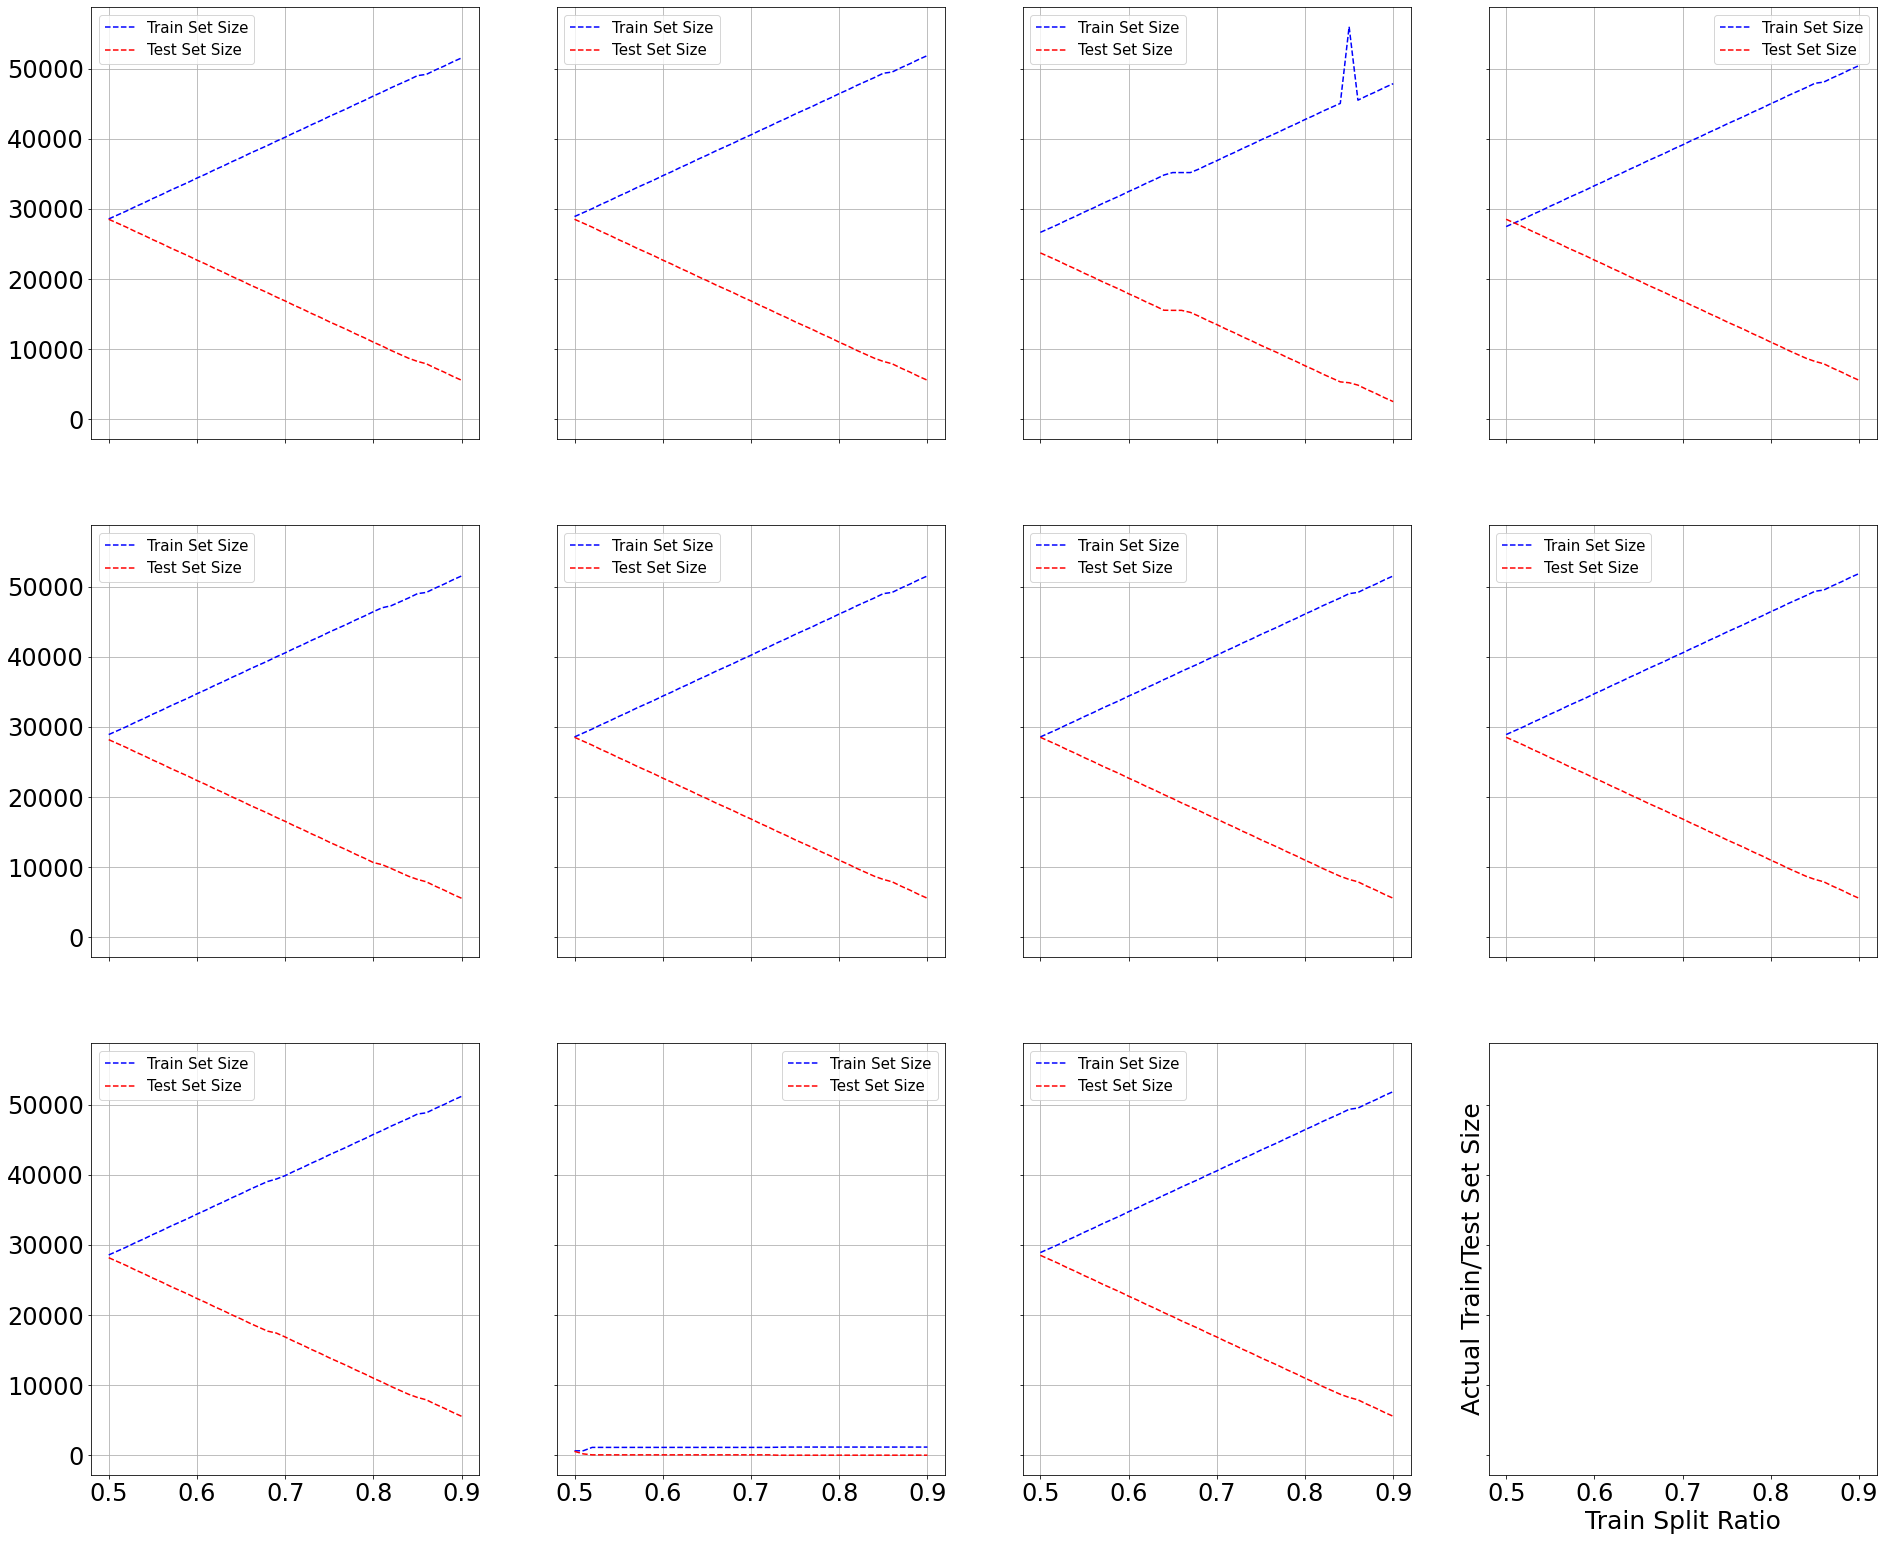

In [19]:
# Make Windows
def makeWindowsFromContinuousSteps(officesData, dateData, history, leadSteps):
    '''
    officesData     : 2-D Numpy Array (number of offices, total number of readings)
    dateData        : 2-D Numpy Array (number of offices, total number of readings)
    history         : Number of TIMESTEPS to be considered as Input to Forecasting Model
    leadSteps       : Number of TIMESTEPS to be considered as Output to Forecasting Model
    '''
    dataX, dataY, officeNumber = [], [], []
    dateX, dateY = [], []
    idxWindows = []

    # If only 1 office data is present, i.e. shape of officesData is
    # (total number of readings,), then reshape to (1, total number of readings)
    if len(officesData.shape)==1:
        officesData = officesData.reshape(1,-1)
    elif not len(officesData.shape)==2:
        raise('Unacceptable input shape of officesData variable - ' + str(officesData.shape))
    
    # If only 1 date data is present, i.e. shape of dateData is
    # (total number of readings,), then reshape to (1, total number of readings)
    if len(dateData.shape)==1:
        dateData = dateData.reshape(1,-1)
    elif not len(dateData.shape)==2:
        raise('Unacceptable input shape of dateData variable - ' + str(dateData.shape))

    for i in range(officesData.shape[0]):
        continuousSubSequenceStartIndex = 0
        continuousSubSequenceStopIndex  = 0
        searchingForNAN = True
        seqCounter = 0
        while seqCounter<len(officesData[i]):
            if seqCounter==len(officesData[i])-1:
                if np.isnan(officesData[i, seqCounter]):
                    continuousSubSequenceStopIndex = seqCounter - 1
                else:
                    continuousSubSequenceStopIndex = seqCounter
                ### Perform continuousSubSequence Operation - Extract Windows ###
                if continuousSubSequenceStopIndex - continuousSubSequenceStartIndex + 1 >= history + leadSteps:
                    for k in range(continuousSubSequenceStartIndex, continuousSubSequenceStopIndex+1):
                        if k + history + leadSteps <= continuousSubSequenceStopIndex + 1:
                            dataX.append(officesData[i, k:k+history])
                            dataY.append(officesData[i, k+history:k+history+leadSteps])
                            officeNumber.append(i)
                            dateX.append(dateData[i, k:k+history])
                            dateY.append(dateData[i, k+history:k+history+leadSteps])
                            idxWindows.append((i, k))
                break
            if not np.isnan(officesData[i, seqCounter]):
                if not searchingForNAN:
                    searchingForNAN = True
                    continuousSubSequenceStartIndex = seqCounter
            else:
                if searchingForNAN:
                    searchingForNAN = False
                    continuousSubSequenceStopIndex = seqCounter - 1
                    ### Perform continuousSubSequence Operation - Extract Windows ###
                    if continuousSubSequenceStopIndex - continuousSubSequenceStartIndex + 1 >= history + leadSteps:
                        for k in range(continuousSubSequenceStartIndex, continuousSubSequenceStopIndex+1):
                            if k + history + leadSteps <= continuousSubSequenceStopIndex + 1:
                                dataX.append(officesData[i, k:k+history])
                                dataY.append(officesData[i, k+history:k+history+leadSteps])
                                officeNumber.append(i)
                                dateX.append(dateData[i, k:k+history])
                                dateY.append(dateData[i, k+history:k+history+leadSteps])
                                idxWindows.append((i, k))
            seqCounter += 1
    return dataX, dataY, officeNumber, dateX, dateY, idxWindows

history = readingsPerDay*5 #== 280 #== 5 Days
leadSteps = readingsPerDay #== 56 #== 1 Day

# For each office, compute train and test split size with varying split order
# and plot the results
fig, axs = plt.subplots(len(officeTS)%4, 4, sharex=True, sharey=True, figsize=((len(officeTS)%4)*11 - 1, 4*7 - 1))
for officeIDX in range(len(officeTS)):
    trainSetSize = []
    testSetSize = []
    for temptrainPart in np.arange(0.5, 0.91, 0.01):
        temptrainSplit = officeTS[officeIDX, :int(temptrainPart*totalDays)*readingsPerDay]
        temptestSplit = officeTS[officeIDX, int(temptrainPart*totalDays)*readingsPerDay:]
        tempDateTrainSplit = dateTS[officeIDX, :int(temptrainPart*totalDays)*readingsPerDay]
        tempDateTestSplit = dateTS[officeIDX, int(temptrainPart*totalDays)*readingsPerDay:]
        temptrainX, temptrainY, tempofficeNumberTrain, _, _, _ = makeWindowsFromContinuousSteps(temptrainSplit, tempDateTrainSplit, history, leadSteps)
        temptestX, temptestY, tempofficeNumberTest, _, _, _ = makeWindowsFromContinuousSteps(temptestSplit, tempDateTestSplit, history, leadSteps)
        trainSetSize.append(len(temptrainX))
        testSetSize.append(len(temptestX))
    plt.rc('font', size=15)         # controls default text sizes
    plt.rc('axes', titlesize=17)    # fontsize of the axes title
    plt.rc('axes', labelsize=17)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=15)   # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)   # fontsize of the tick labels
    plt.rc('legend', fontsize=15)   # legend fontsize
    plt.rc('figure', titlesize=17)  # fontsize of the figure title
    axs[int(officeIDX/4)][int(officeIDX%4)].plot(np.arange(0.5, 0.91, 0.01), trainSetSize, 'b--', label = 'Train Set Size')
    axs[int(officeIDX/4)][int(officeIDX%4)].plot(np.arange(0.5, 0.91, 0.01), testSetSize, 'r--', label = 'Test Set Size')
    axs[int(officeIDX/4)][int(officeIDX%4)].legend()
    axs[int(officeIDX/4)][int(officeIDX%4)].grid(True)
    plt.xlabel('Train Split Ratio')
    plt.ylabel('Actual Train/Test Set Size')

In [20]:
# Perform Train - Test Split
trainPart = 0.80
trainSplit = officeTS[:, :int(trainPart*totalDays)*readingsPerDay]
testSplit = officeTS[:, int(trainPart*totalDays)*readingsPerDay:]

dateTrainSplit = dateTS[:, :int(trainPart*totalDays)*readingsPerDay]
dateTestSplit = dateTS[:, int(trainPart*totalDays)*readingsPerDay:]

print(trainSplit.shape)
print(testSplit.shape)

print(dateTrainSplit.shape)
print(dateTestSplit.shape)

(11, 46760)
(11, 11704)
(11, 46760)
(11, 11704)


**Fit Standard Scaler on Train Set (for individual buildings)**

In [21]:
# # Flatten trainSplit into 1-D array
# trainFlat = trainSplit.flatten()

# Perform Standardization Fit
scaler = StandardScaler()
# scaler = scaler.fit(trainFlat.reshape(-1, 1))
scaler = scaler.fit(np.transpose(trainSplit))
print(color.BOLD+"Scaler Mean \t\t\t Scaler Std Dev"+color.END)
for i in range(len(scaler.mean_)):
    print(scaler.mean_[i], "\t\t", np.sqrt(scaler.var_[i]))

Scaler Mean 			 Scaler Std Dev
66.22655217400603 		 24.767531001296113
141.22887082976902 		 43.971304174079904
54.24292075374291 		 22.832481511509293
13.473159348305467 		 7.293717508732904
18.81993584260051 		 12.131163673555129
54.73652131140529 		 14.217363897172257
13.540599268558719 		 7.433534506482996
10.273028229255774 		 4.10701288239283
9.29211840698122 		 3.2724460619931093
7.190327205530953 		 5.93370953875332
41.19792130025664 		 15.723670578653218


**Perform Standardization on Train and Test Sets**

In [22]:
# Perform Standardization
trainScaled = np.transpose(scaler.transform(np.transpose(trainSplit)))
testScaled = np.transpose(scaler.transform(np.transpose(testSplit)))

print(trainScaled.shape)
print(testScaled.shape)

# Validate Inverse Standardization
inv_trainScaled = np.transpose(scaler.inverse_transform(np.transpose(trainScaled)))
inv_testScaled = np.transpose(scaler.inverse_transform(np.transpose(testScaled)))

print(np.allclose(inv_trainScaled,trainSplit,equal_nan=True))
print(np.allclose(inv_testScaled,testSplit,equal_nan=True))

(11, 46760)
(11, 11704)
True
True


**Make continuous windows by time steps - without NANs**

In [23]:
historySteps = 5*readingsPerDay
leadSteps = 1*readingsPerDay

officeIDX = 2

trainX, trainY, officeNumberTrain, dateTrainX, dateTrainY, idxWindows = makeWindowsFromContinuousSteps(trainScaled[officeIDX], dateTrainSplit[officeIDX], historySteps, leadSteps)
print(len(trainX), len(trainY), len(officeNumberTrain), officeNumberTrain[0])
print(trainX[0].shape, trainY[0].shape)
testX, testY, officeNumberTest, dateTestX, dateTestY, idxWindows = makeWindowsFromContinuousSteps(testScaled[officeIDX], dateTestSplit[officeIDX], historySteps, leadSteps)
print(len(testX), len(testY), len(officeNumberTest), officeNumberTest[0])
print(testX[0].shape, testY[0].shape)

42737 42737 42737 0
(280,) (56,)
7612 7612 7612 0
(280,) (56,)


**Test the Created Arrays**

In [24]:
def calcInvScaledError(scaledPrediction, scaledTruth, errorMetric='RMSE', scaler=None, dataToScalerIndices=None):
    if scaler is not None:
        if dataToScalerIndices is None:
            if len(scaler.mean_) > 1:
                raise("Different scaler used for different datapoints but back reference is not provided - dataToScalerIndices is None!")
            else:
                inv_scaledPrediction = np.transpose(scaler.inverse_transform(np.transpose(scaledPrediction)))
                inv_scaledTruth = np.transpose(scaler.inverse_transform(np.transpose(scaledTruth)))
        else:
            inv_scaledPrediction = deepcopy(scaledPrediction)
            inv_scaledTruth = deepcopy(scaledTruth)
            for i in range(len(scaledPrediction)):
                inv_scaledPrediction[i,:] = (scaledPrediction[i,:]*(scaler.mean_[dataToScalerIndices[i]]))+np.sqrt(scaler.var_[dataToScalerIndices[i]])
                inv_scaledTruth[i,:] = (scaledTruth[i,:]*(scaler.mean_[dataToScalerIndices[i]]))+np.sqrt(scaler.var_[dataToScalerIndices[i]])
        prediction = inv_scaledPrediction
        truth = inv_scaledTruth
    else:
        prediction = scaledPrediction
        truth = scaledTruth
    if errorMetric=='RMSE':
        error = mean_squared_error(truth, prediction, squared=False)
    elif errorMetric=='MSE':
        error = mean_squared_error(truth, prediction, squared=True)
    else:
        raise('Unsupported error metric - ' + errorMetric)
    return error

In [25]:
myTrainX = np.array(trainX)
myTrainY = np.array(trainY)
myOfficeNumberTrain = np.array(officeNumberTrain)
myDateTrainX = np.array(dateTrainX)
myDateTrainY = np.array(dateTrainY)
print(myOfficeNumberTrain.shape, myDateTrainX.shape, myDateTrainY.shape)
myTestX = np.array(testX)
myTestY = np.array(testY)
myOfficeNumberTest = np.array(officeNumberTest)
myDateTestX = np.array(dateTestX)
myDateTestY = np.array(dateTestY)
print(myOfficeNumberTest.shape, myDateTestX.shape, myDateTestY.shape)
print("Before Reshaping")
print(myTrainX.shape, myTrainY.shape)
print(myTestX.shape, myTestY.shape)

# Reshape Input to be [Samples, Time-Steps, Features]
myTrainX = np.reshape(myTrainX, (myTrainX.shape[0], myTrainX.shape[1], 1))
myTestX = np.reshape(myTestX, (myTestX.shape[0], myTestX.shape[1], 1))
print("After Reshaping")
print(myTrainX.shape, myTrainY.shape)
print(myTestX.shape, myTestY.shape)

naive_forecast = myTrainX[:, -56:, 0]
print(naive_forecast.shape)
print('MSE for Naive Forecast on Train Set = ', calcInvScaledError(naive_forecast, myTrainY, errorMetric='MSE', scaler=scaler, dataToScalerIndices=myOfficeNumberTrain))
print('RMSE for Naive Forecast on Train Set = ', calcInvScaledError(naive_forecast, myTrainY, errorMetric='RMSE', scaler=scaler, dataToScalerIndices=myOfficeNumberTrain))

naive_forecast = myTestX[:, -56:, 0]
print(naive_forecast.shape)
print('MSE for Naive Forecast on Test Set = ', calcInvScaledError(naive_forecast, myTestY, errorMetric='MSE', scaler=scaler, dataToScalerIndices=myOfficeNumberTest))
print('RMSE for Naive Forecast on Test Set = ', calcInvScaledError(naive_forecast, myTestY, errorMetric='RMSE', scaler=scaler, dataToScalerIndices=myOfficeNumberTest))


(42737,) (42737, 280) (42737, 56)
(7612,) (7612, 280) (7612, 56)
Before Reshaping
(42737, 280) (42737, 56)
(7612, 280) (7612, 56)
After Reshaping
(42737, 280, 1) (42737, 56)
(7612, 280, 1) (7612, 56)
(42737, 56)
MSE for Naive Forecast on Train Set =  2113.008046833323
RMSE for Naive Forecast on Train Set =  45.96746203516864
(7612, 56)
MSE for Naive Forecast on Test Set =  1125.741786860212
RMSE for Naive Forecast on Test Set =  33.55196908114885


# **Save the Final Scaler and Numpy Array**

In [26]:
# save the scaler
dump(scaler, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/scaler.pkl', 'wb'))

# save the data
dump(officeTS, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/officeTS.pkl', 'wb'))

dump(trainSplit, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/trainSplit.pkl', 'wb'))
dump(testSplit, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/testSplit.pkl', 'wb'))
dump(dateTrainSplit, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/dateTrainSplit.pkl', 'wb'))
dump(dateTestSplit, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/dateTestSplit.pkl', 'wb'))

# Read scaler and data back for cross-verification
scaler_unpickled = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/scaler.pkl', 'rb'))
officeTS_unpickled = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/officeTS.pkl', 'rb'))

print(np.allclose(officeTS,officeTS_unpickled,equal_nan=True))

True
